In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
  
# metadata 
print(wine_quality.metadata) 
  
# variable information 
print(wine_quality.variables) 


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [2]:
# plot y (wine quality scores) distribution with plotly
import plotly.express as px
fig = px.histogram(y, nbins=10, title="Distribution of Wine Quality Scores")
fig.show()

In [6]:
# Binarizza la variabile y: 1 se quality >= 7, altrimenti 0
y_bin = (y['quality'] >= 7).astype(int)
# rename in high_quality
y_bin.rename('high_quality', inplace=True)
print(y_bin.value_counts())

high_quality
0    5220
1    1277
Name: count, dtype: int64


In [8]:
from sklearn.model_selection import train_test_split

# Dividi in train e test set con stratificazione
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train target distribution:\n{y_train.value_counts()}")
print(f"Test target distribution:\n{y_test.value_counts()}")

Train set: 5197 samples
Test set: 1300 samples
Train target distribution:
high_quality
0    4176
1    1021
Name: count, dtype: int64
Test target distribution:
high_quality
0    1044
1     256
Name: count, dtype: int64


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier

# Crea la pipeline scikit-learn pura
pipeline_rf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    ))
])

print("Pipeline creata con successo!")
print(pipeline_rf)

Pipeline creata con successo!
Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=200,
                                        n_jobs=-1, random_state=42))])


2025/11/23 08:16:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/Users/andreacorvaglia/miniforge3/envs/ai-course/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

/Users/andreacorvaglia/miniforge3/envs/ai-course/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning:


Accuracy: 0.8546
Precision: 0.7343
Recall: 0.4102
F1 Score: 0.5263
ROC AUC: 0.8851

Artefatti explainability loggati: feature_importance.png, shap_summary.png


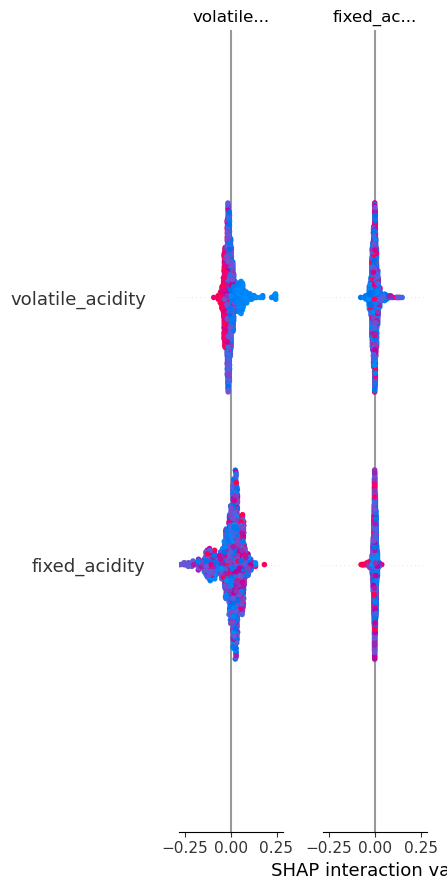

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import shap
import mlflow

# Training con MLflow
with mlflow.start_run(run_name="RandomForest_Wine_Quality"):
    
    # Fit della pipeline
    pipeline_rf.fit(X_train, y_train)
    
    # Predizioni
    y_pred = pipeline_rf.predict(X_test)
    y_pred_proba = pipeline_rf.predict_proba(X_test)[:, 1]
    
    # Calcola metriche
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Log metriche
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("roc_auc", roc_auc)
    
    # Log parametri
    mlflow.log_params(pipeline_rf.named_steps['classifier'].get_params())
    
    # === FEATURE IMPORTANCE ===
    feature_importance = pipeline_rf.named_steps['classifier'].feature_importances_
    feature_names = X_train.columns.tolist()
    
    # Crea grafico feature importance
    fig_fi, ax = plt.subplots(figsize=(10, 6))
    indices = np.argsort(feature_importance)[::-1][:10]  # Top 10 features
    ax.barh(range(len(indices)), feature_importance[indices])
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices])
    ax.set_xlabel('Feature Importance')
    ax.set_title('Top 10 Feature Importances (Random Forest)')
    ax.invert_yaxis()
    plt.tight_layout()
    
    # Salva e logga come artefatto
    fig_fi.savefig('/tmp/feature_importance.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('/tmp/feature_importance.png', artifact_path='explainability')
    plt.close(fig_fi)
    
    # === SHAP VALUES ===
    # Trasforma i dati di test per ottenere l'output del preprocessing
    X_test_transformed = pipeline_rf.named_steps['imputer'].transform(X_test)
    X_test_transformed = pipeline_rf.named_steps['scaler'].transform(X_test_transformed)
    
    # Crea explainer SHAP
    explainer = shap.TreeExplainer(pipeline_rf.named_steps['classifier'])
    shap_values = explainer.shap_values(X_test_transformed)
    
    # Se shap_values è una lista (per classificazione binaria), prendi la classe positiva
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    # Crea summary plot
    fig_shap, ax = plt.subplots(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_transformed, 
                     feature_names=feature_names, 
                     show=False, max_display=10)
    plt.tight_layout()
    
    # Salva e logga come artefatto
    fig_shap.savefig('/tmp/shap_summary.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('/tmp/shap_summary.png', artifact_path='explainability')
    plt.close(fig_shap)
    
    # Log del modello
    mlflow.sklearn.log_model(
        pipeline_rf, 
        "pipeline",
        input_example=X_test.head(5)
    )
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nArtefatti explainability loggati: feature_importance.png, shap_summary.png")